In [446]:
import cairo
import IPython.display
from io import BytesIO
import numpy as np
import math

class Display():
    def __init__(self, w, h):
        self.svgio = BytesIO()
        self.w = w
        self.h = h
        
    def __enter__(self):
        surface = cairo.SVGSurface(self.svgio, self.w, self.h)
        context = cairo.Context(surface)
        self.surface = surface
        self.context = context
        return self.context
    
    def show(self):
        self.surface.finish()
        self.surface.flush()
        return IPython.display.SVG(data=self.svgio.getvalue())
        
    def __exit__(self, type, value, traceback):
        pass

In [447]:
def diamond_grid_pos(w, h, size):
    x1 = np.concatenate([np.full(h + 1, 0), np.arange(size, w * size, size)])
    y1 = np.concatenate([np.arange(0, h * size, size), np.full(w, h * size)])
    x2 = np.concatenate([np.arange(0, w * size, size), np.full(h, w * size)])
    y2 = np.concatenate([np.full(w, 0), np.arange(0, size * h, size)])
    return np.array([x1, y1, x2, y2]).T

def diamond_grid_neg(w, h, size):
    x1 = np.concatenate([np.full(h + 1, 0), np.arange(size, w * size, size)])
    y1 = np.concatenate([np.arange(h * size, 0, -size), np.full(w, 0)])
    x2 = np.concatenate([np.arange(0, w * size, size), np.full(h, w * size)])
    y2 = np.concatenate([np.full(w, h * size), np.arange(h * size, 0, -size)])
    return np.array([x1, y1, x2, y2]).T

def diamond_grid(w, h, size):
    return np.concatenate([
        diamond_grid_pos(w, h, size),
        diamond_grid_neg(w, h, size)
    ])

def square_grid(w, h, size):
    hor_x1 = np.full(h + 1, 0)
    hor_x2 = np.full(h + 1, w * size)
    hor_y1 = np.arange(0, (h + 1) * size, size)
    hor_y2 = hor_y1
    
    ver_x1 = np.arange(0, (w + 1) * size, size)
    ver_x2 = ver_x1
    ver_y1 = np.full(w + 1, 0)
    ver_y2 = np.full(w + 1, h * size)
    
    return np.concatenate([
            np.array([hor_x1, hor_y1, hor_x2, hor_y2]).T,
            np.array([ver_x1, ver_y1, ver_x2, ver_y2]).T
        ])

def draw_simple_lines(context, lines):
    for row in lines:
        x1, y1, x2, y2 = tuple(row)
        context.move_to(x1, y1)
        context.line_to(x2, y2)
        context.stroke()


In [448]:
def of_multiples(across, down):
    direction = 0
    x = 0
    while True:
        x1 = x
        x2 = x1 + across
        yield ()

def of_order():
    pass

In [449]:
def basic_pattern_lines(size):
    # top, bottom
    yield (0 * size, 0 * size, 15 * size, 0 * size)
    yield (0 * size, 2.5 * size, 15 * size, 2.5 * size)
    
    for i in range(3):
        x = i * size * 5
        # down
        yield (x + 0 * size, 0 * size, x + 2 * size, 2 * size)
        yield (x + 2 * size, 2 * size, x + 2.5 * size, 1.5 * size)

        # up
        #x += 0.5
        yield (x + 2.5 * size, 2.5 * size, x + 4.5 * size, .5 * size)
        yield (x + 4.5 * size, .5 * size, x + 5 * size, 1 * size)


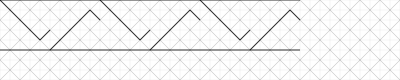

In [450]:
cols = 20
rows = 4
size = 20

display = Display(cols * size, rows * size)

basic_pat = list(basic_pattern_lines(size))

with display as context:
    context.set_line_width(0.5)
    context.set_source_rgba(0, 0, 0, 0.25)
    draw_simple_lines(context, diamond_grid(cols, rows, size))
    context.set_source_rgba(0, 0, 0, 0.08)
    draw_simple_lines(context, square_grid(cols*2, rows*2, size/2))
    
    context.set_line_width(1)
    context.set_source_rgba(0, 0, 0, 0.8)

    draw_simple_lines(context, basic_pat)

display.show()

In [451]:
        
# https://gist.github.com/kylemcdonald/6132fc1c29fd3767691442ba4bc84018
# intersection between line(p1, p2) and line(p3, p4)
def intersect(line1, line2):
    x1,y1,x2,y2 = line1
    x3,y3,x4,y4 = line2
    denom = (y4-y3)*(x2-x1) - (x4-x3)*(y2-y1)
    if denom == 0: # parallel
        return None
    ua = ((x4-x3)*(y1-y3) - (y4-y3)*(x1-x3)) / denom
    if ua < 0 or ua > 1: # out of range
        return None
    ub = ((x2-x1)*(y1-y3) - (y2-y1)*(x1-x3)) / denom
    if ub < 0 or ub > 1: # out of range
        return None
    x = x1 + ua * (x2-x1)
    y = y1 + ua * (y2-y1)
    return (x,y)

def any_intersect(line, lines):
    for other_line in lines:
        if intersect(line, other_line):
            return True
    return False

def lines_parallel(line1, line2):
    x1,y1,x2,y2 = line1
    x3,y3,x4,y4 = line2
    denom = (y4-y3)*(x2-x1) - (x4-x3)*(y2-y1)
    if denom == 0: # parallel
        return True
    return False

def line_projection(line1, line2):
    return np.dot(line1, line2) / np.linalg.norm(line2)

def dist(x1, y1, x2, y2):
    return math.sqrt((y2 - y1) ** 2) + math.sqrt((x2 - x1) ** 2)

# https://en.wikipedia.org/wiki/Distance_from_a_point_to_a_line#Line_defined_by_two_points
def point_line_dist(x0, y0, line):
    x1, y1, x2, y2 = line
    numerator = abs((x2 - x1) * (y1 - y0) - (x1 - x0) * (y2 - y1))
    denom = math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
    return numerator / denom

def line_to_vector(line):
    return np.array([line[2] - line[0], line[3] - line[1]])

def unit_vector(v):
    return v / abs(np.array(v)).max()

# https://stackoverflow.com/questions/1243614/
def normals(line):
    x1, y1, x2, y2 = line
    dx = x2 - x1 
    dy = y2 - y1
    return unit_vector(
        np.array([[-dy, dx],
                  [dy, -dx]]))

def vector_normals(x, y):
    return unit_vector(
        np.array([[-y, x],
                  [y, -x]]))

def point_adjacent(pt, normals, line, max_d):
    for n in normals:
        normal_ray = (*pt, *(pt + n * max_d))
        i_point = intersect(normal_ray, line)
        if i_point is not None:
            final_dist = dist(*pt, *i_point)
            return (tuple(i_point), final_dist, n)
    return None

def get_min_max_walls(walls):
    xs = np.concatenate([
        np.array(walls)[:,0],
        np.array(walls)[:,2]
    ])
    ys = np.concatenate([
        np.array(walls)[:,1],
        np.array(walls)[:,3]
    ])
    return [xs.min(), xs.max(), ys.min(), ys.max()]


In [452]:
def path_find(position, direction, walls, size):
    '''
    args: take position and direction
    return: list of new positions and directions

    rough algorithm
    - Find all adjacent parallel walls within 1/2 square
    - Continue in current direction until intersect with wall or come to end of adjacent wall
    - if intersection
    -    then backtrack 1/2 square from nearest intersection point
    -    Bifurcate in two directions parallel to wall
    -    Find any intersections, if intersection <= 1/2 square distant it is invalid
    -    otherwise recurse for each valid bifurcation
    - elif have adjacent
    -    find end adjacent point
    -    test if double back is out of bounds
    -    if in bounds then double back along the adjacent wall and recurse
    '''
    min_x, max_x, min_y, max_y = get_min_max_walls(walls)
    max_d = max(max_x - min_x, max_y - min_y)

    ray = np.array([
        position[0],
        position[1],
        position[0] + direction[0] * max_d * size,
        position[1] + direction[1] * max_d * size
    ])
    
    adjacent = []
    intersecting = []
    for wall in walls:
        # may want to change this so its from 'position' not 'ray'
        if lines_parallel(tuple(ray), tuple(wall)):

            i_point = point_adjacent(
                np.array(position),
                vector_normals(*direction), wall, 0.25 * size)

            if i_point is not None:
                adjacent.append((np.array(wall), *i_point))

        point = intersect(ray, wall)
        if point is not None:
            intersecting.append((point, wall, dist(*point, *position)))

    use_intersect = False
    use_adjacent = False
    if len(intersecting):
        pt, wall, _ = sorted(intersecting, key=lambda v: v[2])[0]
        d = np.array(direction)
        norm_scaled = 1 / abs(d).sum()
        stop_pt = np.array(pt) + np.array(direction) * -0.5 * size * norm_scaled

    if len(adjacent):
        valid_ends = []
        for adj_wall, ipt, d, n in adjacent:
            for end in adj_wall.reshape(2,2):
                is_adj = point_adjacent(
                    np.array(end),
                    vector_normals(*direction),
                    ray, d)
                adj_wall_remainder_len = dist(*end, *ipt)
                if is_adj and adj_wall_remainder_len > 0:
                    # calc remaining vector
                    delta = np.array(end) - np.array(ipt)
                    valid_ends.append((adj_wall, end, adj_wall_remainder_len, delta, n))

        nearest_adj_wall, adj_end, _, remain, n = sorted(valid_ends, key=lambda v: v[2])[0]
        
    if len(intersecting) and not len(adjacent):
        use_intersect = True
    elif len(adjacent) and not len(intersecting):
        use_adjacent = True
    elif len(intersecting) and len(adjacent):
        if dist(*position, *stop_pt) < dist(*position, *adj_end):
            use_intersect = True
        else:
            use_adjacent = True

    if use_intersect:
        segment = np.array([
            position[0],
            position[1],
            stop_pt[0],
            stop_pt[1]
        ])

        direction1 = unit_vector(line_to_vector(wall))
        direction2 = direction1 * -1
        ray1 = np.array([
            stop_pt[0],
            stop_pt[1],
            stop_pt[0] + direction1[0] * 0.5 * size,
            stop_pt[1] + direction1[1] * 0.5 * size
        ])
        ray2 = np.array([
            stop_pt[0],
            stop_pt[1],
            stop_pt[0] + direction2[0] * 0.5 * size,
            stop_pt[1] + direction2[1] * 0.5 * size
        ])

        if not any_intersect(ray1, walls):
            # recurse
            yield (stop_pt, direction1, [])
        if not any_intersect(ray2, walls):
            # recurse
            yield (stop_pt, direction2, [])

    elif use_adjacent:
        end = adj_end
        proposed_double_bk = np.array(end) + np.array(direction) * size
        if proposed_double_bk[0] > max_x or \
            proposed_double_bk[1] > max_y:
            # out of bounds, so end with this line
            yield (np.array(position) + np.array(direction) * remain, None, [])
            return

        # - if in bounds then double back along the adjacent wall and recurse
        # doubling back:
        # - 1/4 past end of line
        d = np.array(direction)
        past_end = np.array(position) + (remain) + (d * size / 4)
        # - 1/2 distance in direction of normal closest to end
        new_start = past_end + n * size/2
        parts = [
            (*position, *past_end),
            (*past_end, *new_start)
        ]
        new_dir = np.array(direction) * -1
        yield (new_start, new_dir, parts)
    else:
        # out of bounds, so end with this line
        box_walls = np.array([
            [min_x, min_y, max_x, min_y],
            [min_x, min_y, min_x, max_y],
            [min_x, max_y, max_x, max_y],
            [max_x, min_y, max_x, max_y]
        ])
        for wall in box_walls:
            point = intersect(ray, wall)
            if point is not None:
                yield (position, None, [])

class PathFind():
    def __init__(self, position, direction, walls, size):
        self.walls = walls
        self.size = size
        self.current_heads = [(position, direction)]

    def step(self):
        new_heads = []
        for pos, direction in self.current_heads:
            for new_pos, new_dir, paths in path_find(pos, direction, self.walls, self.size):
                if len(paths):
                    for path in paths:
                        yield path
                else:
                    yield (*pos, *new_pos)
                if new_dir is not None:
                    new_heads.append((new_pos, new_dir))
        self.current_heads = new_heads

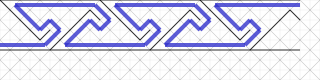

In [455]:

cols = 16
rows = 4
size = 20
display = Display(cols * size, rows * size)

basic_pat = list(basic_pattern_lines(size))
test_pat = np.concatenate([
    basic_pat,
    np.array([[0,2,5,2]]) * size,
#    np.array([[-1,2.1,4,2.1]]) * size,
    np.array([[6,2,8,2]]) * size,
#    np.array([[10.01,2.05,13,2.05]]) * size
])
test_pat = basic_pat

with display as context:
    context.set_line_width(0.5)
    context.set_source_rgba(0, 0, 0, 0.25)
    draw_simple_lines(context, diamond_grid(cols, rows, size))
    context.set_source_rgba(0, 0, 0, 0.08)
    draw_simple_lines(context, square_grid(cols*2, rows*2, size/2))
    
    context.set_line_width(1)
    context.set_source_rgba(0, 0, 0, 0.8)

    draw_simple_lines(context, test_pat)

    context.set_line_width(4)
    context.set_source_rgba(0.2, 0.2, 0.8, 0.8)

    pf = PathFind(np.array([0,2.25]) * size, (1,0), test_pat, size)

    for i in range(21):
        draw_simple_lines(context, list(pf.step()))
    
    #draw_simple_lines(context, list(
    #    path_find(np.array([0,2.25]) * size, (1,0), test_pat, size)
    #))
display.show()

In [550]:
def basic_pattern2_lines(size):
    # top, bottom
    yield (0 * size, 0 * size, 25 * size, 0 * size)
    yield (0 * size, 3 * size, 25 * size, 3 * size)
    
    for i in range(5):
        x = i * size * 6
        # down
        yield (x + 0 * size, 0 * size, x + 2.5 * size, 2.5 * size)
        yield (x + 2.5 * size, 2.5 * size, x + 3.5 * size, 1.5 * size)

        # up
        #x += 0.5
        yield (x + 3 * size, 3 * size, x + 5.5 * size, 0.5 * size)
        yield (x + 5.5 * size, .5 * size, x + 6.5 * size, 1.5 * size)

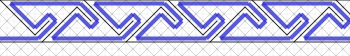

In [557]:
cols = 25
rows = 4
size = 14
display = Display(cols * size, rows * size)

basic_pat = list(basic_pattern2_lines(size))
test_pat = basic_pat

with display as context:
    context.set_line_width(0.5)
    context.set_source_rgba(0, 0, 0, 0.25)
    draw_simple_lines(context, diamond_grid(cols, rows, size))
    context.set_source_rgba(0, 0, 0, 0.08)
    draw_simple_lines(context, square_grid(cols*2, rows*2, size/2))
    
    context.set_line_width(1)
    context.set_source_rgba(0, 0, 0, 0.8)

    draw_simple_lines(context, test_pat)

    context.set_line_width(4)
    context.set_source_rgba(0.2, 0.2, 0.8, 0.8)

    pf = PathFind(np.array([0,2.75]) * size, (1,0), test_pat, size)

    for i in range(33):
        draw_simple_lines(context, list(pf.step()))

display.show()